# Project Overview

## Objective

The objective of this project is to analyze a public dataset of customers from a telecom company and predict whether a customer will switch to another company, thereby increasing profitability. 

## Dataset Description

- This project utilizes a public dataset of 66,469 customers from an anonymous telecommunications company.
- The goal of the project is to predict customer churn and increase profitability for the company.
- Data preprocessing and cleaning techniques were used on 66 features before moving to the modelling phase.

# Environment Setup

In [1]:
#General
import pandas as pd
import numpy as np
import sklearn
import shap 
#Preprocessing
from itertools import cycle
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.feature_selection import RFECV, RFE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
#Models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans 
#Model_Evaluation
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report, average_precision_score
# from sklearn.metrics import plot_confusion_matrix, 
from sklearn.metrics import roc_auc_score, precision_recall_curve
#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
#Setting_Parameters
import warnings
warnings.filterwarnings('ignore')
sns.set()
style.use('ggplot')
pd.set_option("display.max_rows", 100)
%matplotlib inline 
plt.rcParams["figure.figsize"] = (12, 8)
cmap = LinearSegmentedColormap.from_list("", ['#FFFFFF',"#FFF5BD","#FF4646",'#E41A1C',"#960018"])
DATA_PATH = "/home/decaro/xai-hack/data/credit_card_churn.csv"


In [2]:
def reduce_mem_usage(train_data):
    """ iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data


# Preparation & Cleanup

In [3]:
%%time
df = pd.read_csv(DATA_PATH)
df.head()

CPU times: user 14.5 ms, sys: 4.07 ms, total: 18.5 ms
Wall time: 17.8 ms


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
print('Feature names: \n',df.columns)

Feature names: 
 Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


In [5]:
df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


In [7]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.62 MB
Memory usage after optimization is: 0.31 MB
Decreased by 80.9%


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12688.0,777,11912.0,1.334961,1144,42,1.625000,0.061005
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541016,1291,33,3.714844,0.104980
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.593750,1887,20,2.332031,0.000000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3312.0,2517,796.0,1.405273,1171,20,2.332031,0.759766
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175781,816,28,2.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4004.0,1851,2152.0,0.703125,15476,117,0.856934,0.461914
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4276.0,2186,2092.0,0.804199,8764,69,0.683105,0.511230
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5408.0,0,5408.0,0.818848,10291,60,0.817871,0.000000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5280.0,0,5280.0,0.535156,8395,62,0.722168,0.000000


# Data Preprocessing

### Checking for null values 

In [8]:
null = df.isnull().sum().sum()
print('-'*40)
print('Null values check')
print('-'*40)
print('There is {} null values in the Data Frame'.format(null))

----------------------------------------
Null values check
----------------------------------------
There is 0 null values in the Data Frame


In [9]:
from sklearn.preprocessing import LabelEncoder

df_vanilla = df.copy()

le_Education_Level = LabelEncoder()
le_Gender = LabelEncoder()
le_Income_Category = LabelEncoder()
le_Card_Category = LabelEncoder()
le_Marital_Status = LabelEncoder()

df['Education_Level_n'] = le_Education_Level.fit_transform(df['Education_Level'])
df['Income_Category_n'] = le_Income_Category.fit_transform(df['Income_Category'])
df['Card_Category_n'] = le_Card_Category.fit_transform(df['Card_Category'])
df['Gender_n'] = le_Gender.fit_transform(df['Gender'])
df['Marital_Status_n'] = le_Marital_Status.fit_transform(df['Marital_Status'])

df = df.drop([ 'Education_Level',  'Income_Category', 'Card_Category','CLIENTNUM', 'Gender', 'Marital_Status'], axis = 1)
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer' : 1,'Attrited Customer':0})
df.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_n,Income_Category_n,Card_Category_n,Gender_n,Marital_Status_n
0,1,45,3,39,5,1,3,12688.0,777,11912.0,1.334961,1144,42,1.625000,0.061005,3,2,0,1,1
1,1,49,5,44,6,1,2,8256.0,864,7392.0,1.541016,1291,33,3.714844,0.104980,2,4,0,0,2
2,1,51,3,36,4,1,0,3418.0,0,3418.0,2.593750,1887,20,2.332031,0.000000,2,3,0,1,1
3,1,40,4,34,3,4,1,3312.0,2517,796.0,1.405273,1171,20,2.332031,0.759766,3,4,0,0,3
4,1,40,3,21,5,1,0,4716.0,0,4716.0,2.175781,816,28,2.500000,0.000000,5,2,0,1,1


### Correlation Inspection 

In [10]:
def correlation_heatmap(df, fig=20, annot=False, filtering=None,sort=True, name='plots/pearson_corr', title='Pearson Correlation of Features'):
    """
    Create a correlation matrix with respect to the most correlated variables, and the ability 
    to filter the correlation matrix by pourcentage between 0-1"""
    if sort == True:
        cols1=[]
        cols2=[]
        value=[]
        matrix = df.corr()
        for i in range(len(matrix.columns)):
            for j in range(i):
                cols1.append(matrix.columns[i])
                cols2.append(matrix.columns[j])
                value.append(matrix.iloc[i,j])
        new_df = pd.DataFrame({'column_name_1': cols1, 'column_name_2': cols2, 'corr':value})
        new_df.sort_values('corr',ascending=False, inplace=True)
    
        if filtering != None:
            new_df = new_df[(abs(new_df['corr']) >= filtering)]
    
        all_cols = []
        cols = []
        for index, row in new_df.iterrows():
            all_cols.append(row.column_name_1)
            all_cols.append(row.column_name_2)
        for col in all_cols:
            if col not in cols:
                cols.append(col)
        final = df[cols]
    else:
        final = df.copy()
    _ , ax = plt.subplots(figsize =(fig, fig))
    colormap = sns.diverging_palette(240, 10,n=9, as_cmap = True)
    
    _ = sns.heatmap(
        final.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=annot, 
        linewidths=0.1,
        vmin=-1, 
        vmax=1.0, 
        linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title(title, y=1.05, size=15)
    if name == 'title':
        name = str(tittle)
    plt.savefig(name+".png",transparent=True)
    

#### Correlation matrix of the data

In [11]:
PLOT_PATH = '../experiments/plots'

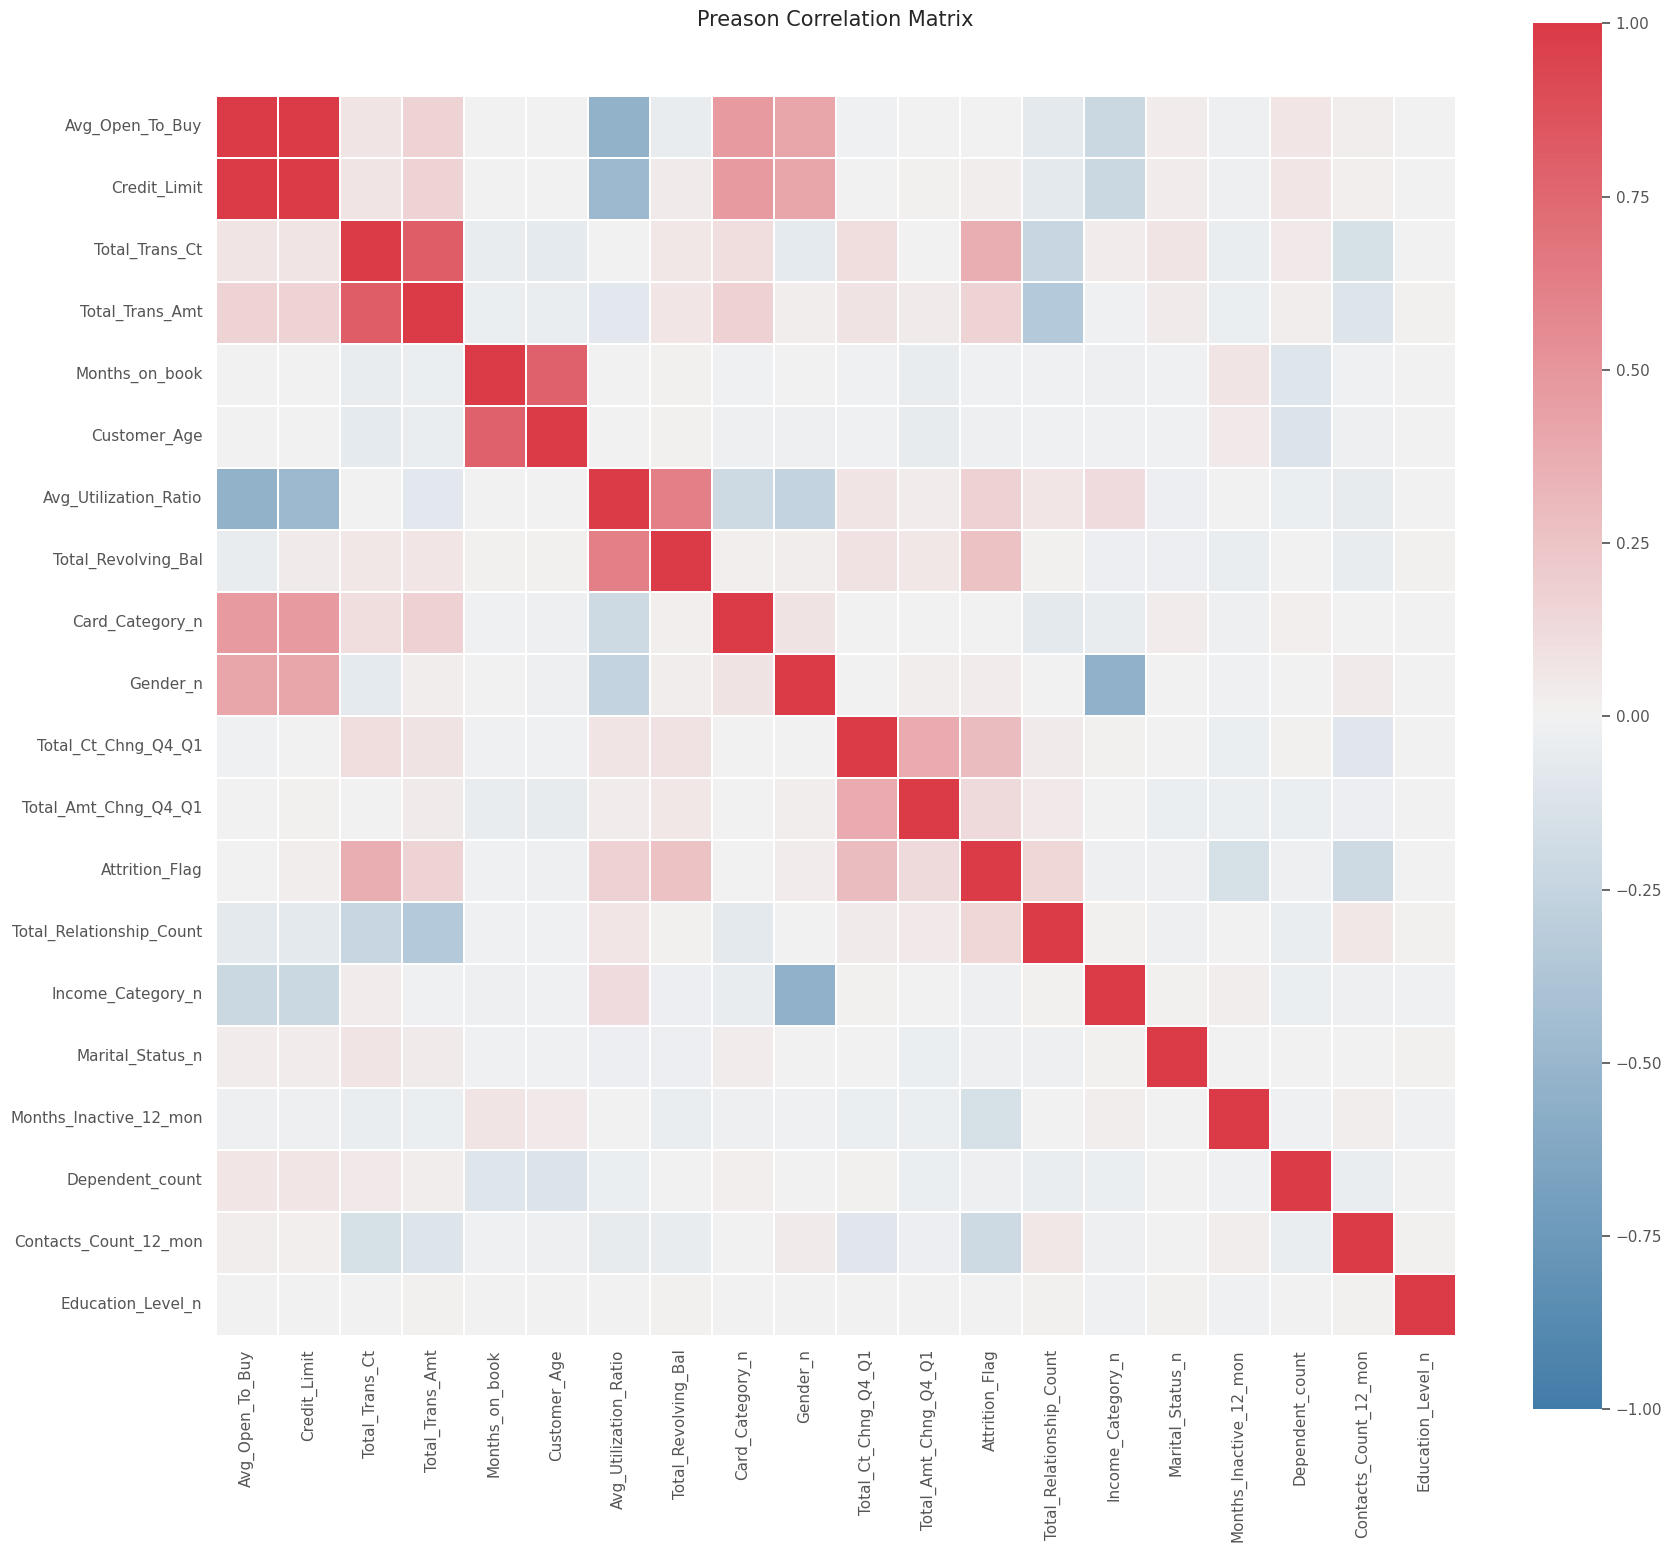

In [12]:
correlation_heatmap(df, sort=True, title='Preason Correlation Matrix', name=f'{PLOT_PATH}/corr_all_feat')

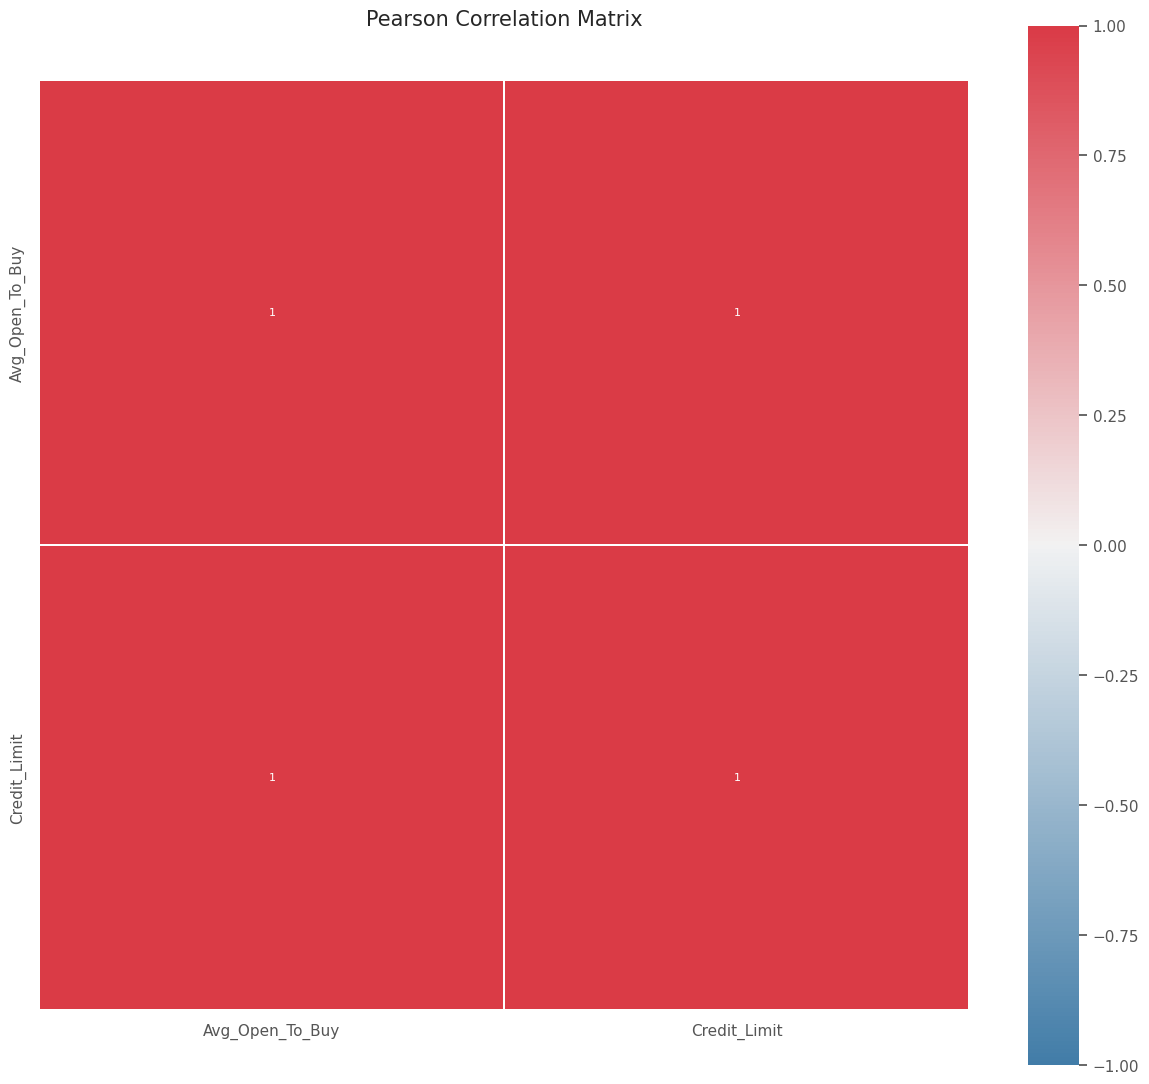

In [13]:
correlation_heatmap(df, fig=15,sort=True, name=f'{PLOT_PATH}/corr_filtrd_feat', annot=True, filtering=0.85, title='Pearson Correlation Matrix')

* The correlation matrix of the dropped columns shows that every column has at least one or more columns in which the correlation exceeds 85%.

#### Correlation matrix after filtering

In [14]:
cols1=[]
cols2=[]
value=[]
matrix = df.corr()
for i in range(len(matrix.columns)):
    for j in range(i):
        cols1.append(matrix.columns[i])
        cols2.append(matrix.columns[j])
        value.append(matrix.iloc[i,j])
new_df = pd.DataFrame({'Feature Name 1': cols1, 'Feature Name 2': cols2, 'Correlation':value})
new_df.sort_values('Correlation',ascending=False, inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df = new_df[new_df['Correlation']>0.85]
new_df['Feature Name 1'].unique()

array(['Avg_Open_To_Buy'], dtype=object)

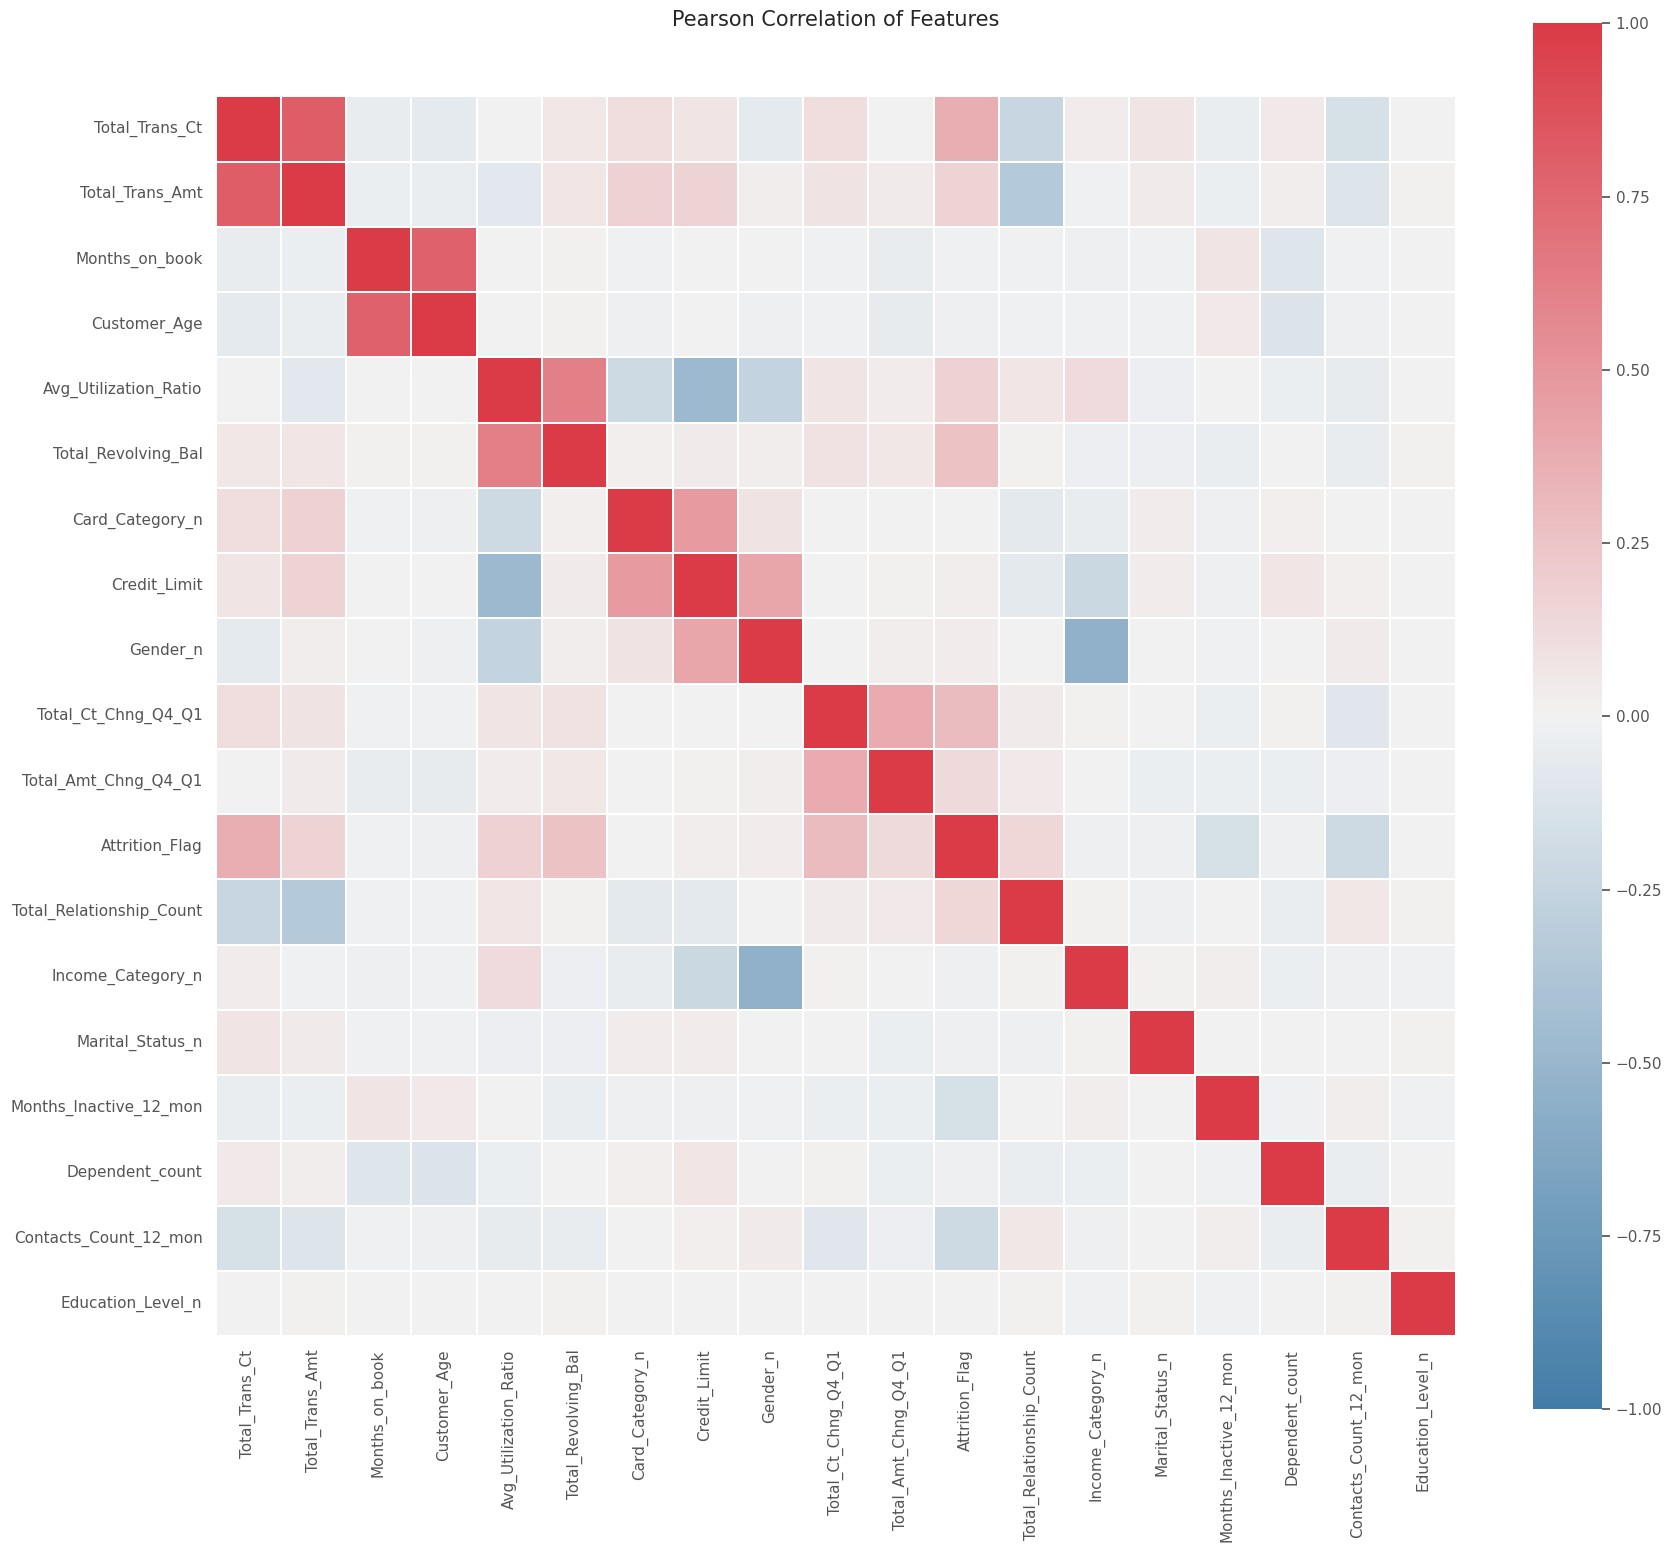

In [15]:
cols1=[]
matrix = df.corr()
for i in range(len(matrix.columns)):
    for j in range(i):
        if abs(matrix.iloc[i,j]) >= 0.85:
            cols1.append(matrix.columns[i])
dropped = df.drop(cols1, axis=1)
correlation_heatmap(dropped, name=f'{PLOT_PATH}/reduced_correlation_heatmap')

* After dropping the correlated columns, the new data seems to be clear of extreem correlations.

In [16]:
dropped.shape

(10127, 19)

# Exploratory Data Analysis

### Standardizing the Data 

In [17]:
#new_churn = new.churn
#new_X = new[new.columns.difference(['churn'])]
#new_X = scaler.fit_transform(new_X)
#new_X = pd.DataFrame(new_X, columns=cols)
#new_X.head()

y_data = dropped["Attrition_Flag"]
x_data = dropped[dropped.columns.difference(['Attrition_Flag'])]
x_cols = x_data.columns
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
x_data = pd.DataFrame(x_data, columns=x_cols)
x_data

,Avg_Utilization_Ratio,Card_Category_n,Contacts_Count_12_mon,Credit_Limit,Customer_Age,Dependent_count,Education_Level_n,Gender_n,Income_Category_n,Marital_Status_n,Months_Inactive_12_mon,Months_on_book,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Total_Relationship_Count,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct
0,-0.775864,-0.259473,0.492404,0.446147,-0.165406,0.503368,-0.052637,1.059956,-0.574182,-0.628128,-1.327136,0.384621,2.623333,3.833917,0.763943,-0.473422,-0.959707,-0.973895
1,-0.616344,-0.259473,-0.411616,-0.041420,0.333570,2.043199,-0.597678,-0.943436,0.755053,0.727306,-1.327136,1.010715,3.563386,12.611850,1.407306,-0.366667,-0.916433,-1.357340
2,-0.997154,-0.259473,-2.219655,-0.573651,0.583058,0.503368,-0.597678,1.059956,0.090436,-0.628128,-1.327136,0.008965,8.366120,6.803648,0.120579,-1.426858,-0.740982,-1.911206
3,1.758845,-0.259473,-1.315636,-0.585312,-0.789126,1.273283,-0.052637,-0.943436,0.755053,2.082739,1.641478,-0.241473,2.944109,6.803648,-0.522785,1.661686,-0.951758,-1.911206
4,-0.997154,-0.259473,-2.219655,-0.430857,-0.789126,0.503368,1.037447,1.059956,-0.574182,-0.628128,-1.327136,-1.869317,6.459283,7.509164,0.763943,-1.426858,-1.056263,-1.570365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.678408,-0.259473,0.492404,-0.509184,0.458314,-0.266547,-0.597678,1.059956,-1.238799,0.727306,-0.337598,0.509840,-0.259198,0.607822,-0.522785,0.844455,3.259358,2.221481
10123,0.857300,-0.259473,0.492404,-0.479262,-0.664382,-0.266547,1.582489,1.059956,-1.238799,-1.983561,-0.337598,-1.368442,0.201918,-0.122305,0.120579,1.255524,1.283475,0.176440
10124,-0.997154,-0.259473,1.396424,-0.354730,-0.290150,-1.036462,-0.052637,-0.943436,0.755053,-0.628128,0.651940,0.008965,0.268746,0.443748,0.763943,-1.426858,1.732994,-0.207005
10125,-0.997154,-0.259473,0.492404,-0.368811,-2.036565,-0.266547,-0.597678,1.059956,-1.238799,2.082739,0.651940,0.008965,-1.025497,0.041768,0.120579,-1.426858,1.174848,-0.121795


### Train-Test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split( x_data, y_data, test_size=0.2, random_state=23, stratify=y_data)
name = []
shape = []
data = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}
for key, value in data.items():
    name.append(key)
    shape.append(len(value))

## Dealing with calss imbalance

Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

### Checking for Class Imbalances

In [19]:
pourc = pd.DataFrame(y_train).value_counts()/len(y_train)*100
pourc


Attrition_Flag
1                 83.92791
0                 16.07209
Name: count, dtype: float64

### Resampling

In [20]:
smote = SMOTE(sampling_strategy=0.6, random_state=23)
X_sm, y_sm = smote.fit_resample(X_train,y_train)
y_sm.shape


under = RandomUnderSampler(random_state=23)

X, y = under.fit_resample(X_sm, y_sm)

print('y_train = {}, y_sm = {}, y = {} '.format(y_train.shape[0],y_sm.shape[0],y.shape[0]))

pourc = dropped[['Attrition_Flag']].value_counts()/len(dropped)*100
print(pourc)

pourc2 = y_sm.value_counts()/len(y_sm)*100
print(pourc2)

pourc3 = y.value_counts()/len(y)*100
pourc3 = pd.DataFrame(pourc3).round().reset_index()
print(pourc3)

# WE USE UNDERSAMPLES DATA
#X_train = X
#y_train = y

y_train = 8101, y_sm = 10878, y = 8158 
Attrition_Flag
1                 83.934038
0                 16.065962
Name: count, dtype: float64
Attrition_Flag
1    62.502298
0    37.497702
Name: count, dtype: float64
  Attrition_Flag  count
0              0   50.0
1              1   50.0


## Feature Selection 

Feature selection is the process of identifying a subset of important features/attributes (such as a column in tabular data) that are most relevant to the modeling and business objectives of the problem. It essentially aids in the extraction of the most meaningful inputs from the data.

### Recursive feature elimination with cross validation and random forest classification (RFECV)

Basically, it uses one of the classification methods (random forest in our example), assign weights to each of features. Whose absolute weights are the smallest are pruned from the current set features, in contrast with RFF, we will not only find best features but we also find how many features do we need for best accuracy.

In [21]:
%%time

cv = KFold(n_splits=5, shuffle=True, random_state=23)
clf = RandomForestClassifier(n_jobs=-1) 
rfecv = RFECV(estimator=clf, step=1, cv=cv,scoring='recall', n_jobs=-1)   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 15
Best features : Index(['Avg_Utilization_Ratio', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Customer_Age', 'Dependent_count', 'Education_Level_n',
       'Income_Category_n', 'Months_Inactive_12_mon', 'Months_on_book',
       'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1',
       'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Trans_Amt',
       'Total_Trans_Ct'],
      dtype='object')
CPU times: user 6.88 s, sys: 4.22 s, total: 11.1 s
Wall time: 14.8 s


**30** is the ideal number of features which was determined by the RFECV algorithm

In [22]:
keep_cols = X_train.columns[rfecv.support_]
to_remove = X_train.columns.difference(keep_cols)
X_train.columns.difference(keep_cols), keep_cols

(Index(['Card_Category_n', 'Gender_n', 'Marital_Status_n'], dtype='object'),
 Index(['Avg_Utilization_Ratio', 'Contacts_Count_12_mon', 'Credit_Limit',
        'Customer_Age', 'Dependent_count', 'Education_Level_n',
        'Income_Category_n', 'Months_Inactive_12_mon', 'Months_on_book',
        'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1',
        'Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Trans_Amt',
        'Total_Trans_Ct'],
       dtype='object'))

In [23]:
print(to_remove)

Index(['Card_Category_n', 'Gender_n', 'Marital_Status_n'], dtype='object')


In [24]:
X_train = X_train[keep_cols]
X_test = X_test[keep_cols]

# Model Selection

### Choosing the best model by Cross-Validation

In [25]:
%%time
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(copy_X_train=False),
    
    #GLM
    linear_model.LogisticRegressionCV(solver='liblinear'),
    #linear_model.PassiveAggressiveClassifier(),
    #linear_model.RidgeClassifierCV(),
    #linear_model.SGDClassifier(),
    #linear_model.Perceptron(),
    
    #Navies Bayes
    #naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    #neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    #svm.LinearSVC(),
    
    #Trees    
    #tree.DecisionTreeClassifier(),
    tree.DecisionTreeClassifier(),
    
    #Discriminant Analysis
    #discriminant_analysis.LinearDiscriminantAnalysis(),
    #discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    #-XGBClassifier(),
    
    #LightGBM
    LGBMClassifier(n_jobs=1),
    ]


#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['Name','Accuracy','Recall', 'Precision', 'F1_score']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
#MLA_predict = y.copy()

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    #MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    #scoring = ['accuracy','precision', 'recall', 'f1_weighted']
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    cv_results = model_selection.cross_validate(alg, X_train, y_train,cv  = cv_split, scoring=scoring, n_jobs=-1)
    MLA_compare.loc[row_index, 'Fit Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'Accuracy'] = cv_results['test_accuracy'].mean()
    #print(cv_results['test_accuracy'].mean())
    MLA_compare.loc[row_index, 'Recall'] = cv_results['test_recall'].mean()
    MLA_compare.loc[row_index, 'Recall_STD'] = cv_results['test_recall'].std()
    MLA_compare.loc[row_index, 'Precision'] = cv_results['test_precision'].mean()
    MLA_compare.loc[row_index, 'F1_score'] = cv_results['test_f1_score'].mean()
    #MLA_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    #MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_accuracy'].std()*3   #let's know the worst that can happen!
    print(cv_results['fit_time'].mean(), '==>  ',MLA_name, 'is done!')

    

    #save MLA predictions - see section 6 for usage
    #alg.fit(X, y)
    #y_predict = alg.predict(X_test)
    #print(classification_report(y_test, y_predict))
    #print('-'*25)
    
    row_index+=1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['Recall'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

/home/decaro/.conda/envs/xaihack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/decaro/.conda/envs/xaihack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/decaro/.conda/envs/xaihack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/decaro/.conda/envs/xaihack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

0.25657594203948975 ==>   AdaBoostClassifier is done!
0.2151418924331665 ==>   BaggingClassifier is done!
0.27133610248565676 ==>   ExtraTreesClassifier is done!
1.1334261178970337 ==>   GradientBoostingClassifier is done!
0.599407148361206 ==>   RandomForestClassifier is done!
0.3311591625213623 ==>   LogisticRegressionCV is done!
0.003413963317871094 ==>   GaussianNB is done!
1.2299195289611817 ==>   SVC is done!
0.03519883155822754 ==>   DecisionTreeClassifier is done!
[LightGBM] [Info] Number of positive: 4063, number of negative: 797
[LightGBM] [Info] Number of positive: 4075, number of negative: 785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.


,Name,Accuracy,Recall,Precision,F1_score,Fit Time,Recall_STD
2,ExtraTreesClassifier,0.942781,0.989602,0.945058,0.966808,0.271336,0.003035
3,GradientBoostingClassifier,0.963801,0.987597,0.969973,0.978702,1.133426,0.002562
4,RandomForestClassifier,0.959399,0.987016,0.965551,0.976159,0.599407,0.003551
9,LGBMClassifier,0.968819,0.985937,0.977248,0.981568,0.122817,0.002206
7,SVC,0.932538,0.978962,0.943117,0.960691,1.229920,0.004433
0,AdaBoostClassifier,0.954422,0.977689,0.968508,0.97307,0.256576,0.003535
1,BaggingClassifier,0.953147,0.972216,0.97216,0.972184,0.215142,0.003630
5,LogisticRegressionCV,0.902674,0.962986,0.924603,0.943383,0.331159,0.006330
8,DecisionTreeClassifier,0.934718,0.959325,0.963036,0.961162,0.035199,0.006500
6,GaussianNB,0.882723,0.925175,0.934892,0.92998,0.003414,0.008725


In [26]:
MLA_compare.sort_values(by = ['F1_score'], ascending = False, inplace = True)
MLA_compare

,Name,Accuracy,Recall,Precision,F1_score,Fit Time,Recall_STD
9,LGBMClassifier,0.968819,0.985937,0.977248,0.981568,0.122817,0.002206
3,GradientBoostingClassifier,0.963801,0.987597,0.969973,0.978702,1.133426,0.002562
4,RandomForestClassifier,0.959399,0.987016,0.965551,0.976159,0.599407,0.003551
0,AdaBoostClassifier,0.954422,0.977689,0.968508,0.97307,0.256576,0.003535
1,BaggingClassifier,0.953147,0.972216,0.97216,0.972184,0.215142,0.003630
2,ExtraTreesClassifier,0.942781,0.989602,0.945058,0.966808,0.271336,0.003035
8,DecisionTreeClassifier,0.934718,0.959325,0.963036,0.961162,0.035199,0.006500
7,SVC,0.932538,0.978962,0.943117,0.960691,1.229920,0.004433
5,LogisticRegressionCV,0.902674,0.962986,0.924603,0.943383,0.331159,0.006330
6,GaussianNB,0.882723,0.925175,0.934892,0.92998,0.003414,0.008725


#### Comparing top models on test data using confusion matrix

In [27]:
%%time
#X_train = ch66_X_train[].copy()
#y_train = ch66_y_train.copy()
#X_test = ch66_X_test[ch66_cols].copy()
#y_test = ch66_y_test.copy()
kfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=23)
my_scorer = make_scorer(f1_score)
model = LGBMClassifier()
#knn = model.fit(ch66_X_train[ch66_cols],ch66_y_train)
model_selection.cross_val_score(model, X_train, y_train, cv=kfolds, scoring=my_scorer, n_jobs=1)

[LightGBM] [Info] Number of positive: 4532, number of negative: 868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 5400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.839259 -> initscore=1.652727
[LightGBM] [Info] Start training from score 1.652727
[LightGBM] [Info] Number of positive: 4533, number of negative: 868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 5401, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.839289 -> initscore=1.652948
[LightGBM] [Info] Start training from score 1.652948
[LightGBM] [Info] Number

array([0.98271713, 0.98024583, 0.98181818])

In [28]:
%%time
#X_train = ch66_X_train[].copy()
#y_train = ch66_y_train.copy()
#X_test = ch66_X_test[ch66_cols].copy()
#y_test = ch66_y_test.copy()
kfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=23)
my_scorer = make_scorer(f1_score)
model = sklearn.ensemble.GradientBoostingClassifier()
#knn = model.fit(ch66_X_train[ch66_cols],ch66_y_train)
model_selection.cross_val_score(model, X_train, y_train, cv=kfolds, scoring=my_scorer, n_jobs=1)

CPU times: user 3.9 s, sys: 19.8 ms, total: 3.92 s
Wall time: 3.92 s


array([0.97860262, 0.97743702, 0.97990389])

In [29]:
fit = model.fit(X_train, y_train)
y_predict = fit.predict(X_test)
f1_score(y_test,y_predict)

np.float64(0.9784633294528522)

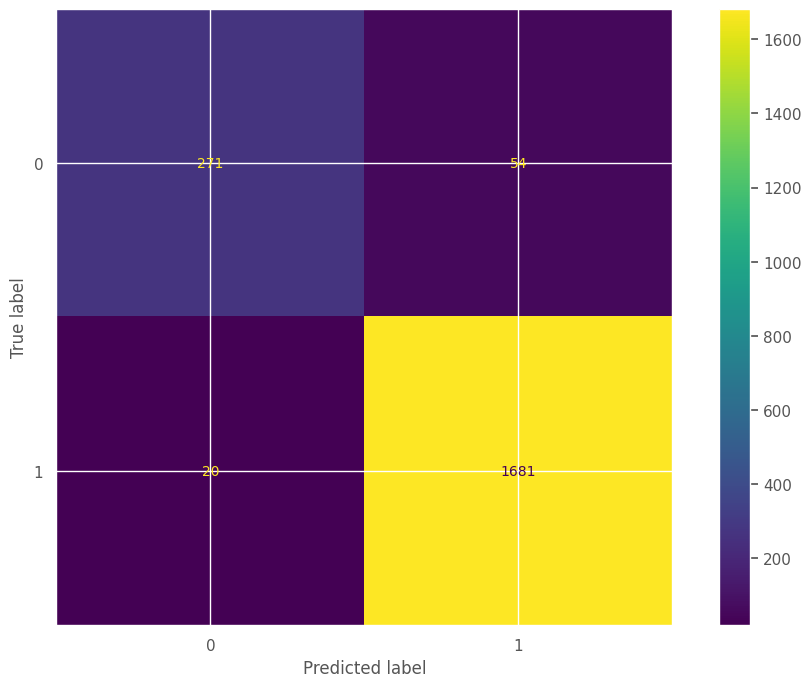

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

As expected, the previous results are confirmed, thus, we will be using XGBoost model.

### Hyperparameter Tuning 

> Acquiring a new custommer costs **5 times** than kepping an existing one
##### The goal here is to improve the model in in the 'Recall' score in order to detect the maximum number of churners.

## Explainability via XAI-Lib

In [31]:
from xailib.data_loaders.dataframe_loader import prepare_dataframe

from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer

from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

bbox = sklearn_classifier_wrapper(fit)

class_field = 'Attrition_Flag'

In [32]:
y_train_pred = fit.predict(X_train)
print(np.argwhere(y_train_pred != y_train).reshape((-1)))

[  30   38   66  177  178  231  281  422  433  466  502  528  570  633
  643  682  748  788  789  800  806  821  824  893  920  942  945  961
  977 1005 1017 1081 1095 1122 1228 1262 1276 1355 1405 1422 1465 1488
 1500 1529 1569 1570 1571 1693 1714 1774 1819 1823 1926 1936 1986 2018
 2024 2094 2107 2132 2163 2248 2251 2331 2370 2389 2418 2434 2465 2502
 2524 2552 2556 2578 2632 2661 2684 2748 2750 2867 2937 2966 2980 2991
 2993 3003 3006 3013 3014 3170 3200 3259 3272 3306 3378 3390 3545 3568
 3606 3713 3735 3816 3822 3826 3838 3859 3876 3883 3891 3897 3910 3961
 4074 4107 4151 4161 4301 4341 4371 4387 4393 4396 4398 4455 4477 4480
 4488 4555 4609 4628 4808 4871 4884 4917 4997 4999 5078 5127 5161 5184
 5385 5391 5475 5512 5579 5620 5660 5718 5737 5739 5790 5806 5813 5952
 5994 5998 6008 6044 6058 6084 6101 6111 6124 6138 6195 6262 6313 6326
 6327 6364 6386 6418 6466 6500 6557 6595 6674 6683 6760 6871 6964 6968
 6972 7130 7222 7277 7278 7322 7359 7382 7393 7437 7472 7536 7688 7710
 7769 

In [33]:
y_test_pred = fit.predict(X_test)
print(np.argwhere(y_test_pred != y_test).reshape((-1)))

[   4   16   26   46  129  137  172  229  232  243  253  292  313  325
  340  354  505  550  577  587  595  610  611  637  639  643  688  696
  761  781  826  835  871  901  902  947  984 1001 1033 1039 1071 1082
 1134 1135 1244 1263 1267 1288 1289 1384 1387 1388 1434 1481 1483 1538
 1548 1559 1568 1576 1622 1673 1696 1732 1782 1784 1787 1880 1881 1964
 1994 2007 2009 2020]


In [34]:
inst = X_train.iloc[147].values
print('Instance ',inst)
print('True class ',y_train.iloc[147])
print('Predicted class ', fit.predict(inst.reshape(1, -1)))

Instance  [-0.9971541   0.49240377 -0.69488225  0.0840824   0.50336813 -0.0526366
  0.75505294 -1.32713603 -0.61712943 -0.86733678  0.59551645  0.76394261
 -1.42685834  0.14422115  1.02854084]
True class  1
Predicted class  [1]


In [35]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(dropped[dropped.columns.difference(to_remove)], class_field, config)
exp = explainer.explain(inst)
print(exp)

### lime Values

In [36]:
y_test_pred = fit.predict(X_test)

# Concatenate predictions with the test data
cat_df = X_test.copy()
cat_df["y_true"] = y_test
cat_df["y_pred"] = y_test_pred


In [37]:
print(X_train)
y_train

      Avg_Utilization_Ratio  Contacts_Count_12_mon  Credit_Limit  \
9207              -0.275387              -0.411616     -0.150990   
5974              -0.848483              -0.411616      0.561438   
4243               1.062760              -0.411616     -0.752308   
1521               0.108965               1.396424     -0.406655   
4843               1.702166               0.492404     -0.756378   
...                     ...                    ...           ...   
4528              -0.496788               1.396424      0.050109   
2332              -0.148303              -0.411616     -0.026458   
4526              -0.692506               0.492404      1.338553   
1833               1.298331              -0.411616     -0.707203   
4497               1.252279              -1.315636     -0.706323   

      Customer_Age  Dependent_count  Education_Level_n  Income_Category_n  \
9207      0.707802        -0.266547          -0.052637          -0.574182   
5974     -0.040662         1.

9207    1
5974    1
4243    1
1521    1
4843    1
       ..
4528    1
2332    0
4526    1
1833    1
4497    1
Name: Attrition_Flag, Length: 8101, dtype: category
Categories (2, int64): [0, 1]

In [38]:

from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

bbox = sklearn_classifier_wrapper(fit)   

shapExplainer = ShapXAITabularExplainer(bbox, X_train.columns)
config = {'explainer' : 'tree', 'X_train' : X_train.values}
shapExplainer.fit(config)
shap_df = pd.concat([X_train, y_train], axis=1)
# lime_exp = limeExplainer.explain(inst)
# print(lime_exp.exp.as_list())

# Create new dataset with the features of lime from the test set
explained_entries = []
for entry, y_gt in zip(X_test.values, y_test.values):
    exp_list = shapExplainer.explain(entry).exp
    dict_entry = {}
    for i, exp in enumerate(exp_list):
        dict_entry[X_test.columns[i]] = exp_list[i]
    y_hat = fit.predict([entry])
    # Predict the entry if y_gt different from the prediction
    dict_entry["Mismatch"] = (y_gt != y_hat).item()
    explained_entries.append(dict_entry)

# Create dataframe
shap_explained_df = pd.DataFrame(explained_entries)

# Replace nan with zeros
#explained_df = explained_df.fillna(0)
shap_explained_df.head()

sns.barplot(shap_explained_df[shap_explained_df['Mismatch']==False].drop(columns=['Mismatch']).abs())
plt.xticks(rotation=30)
plt.savefig(f'{PLOT_PATH}/shap_match')

plt.close()
sns.barplot(shap_explained_df[shap_explained_df['Mismatch']==True].drop(columns=['Mismatch']).abs())
plt.xticks(rotation=30)
plt.savefig(f'{PLOT_PATH}/shap_mismatch')
plt.close()
correlation_heatmap(shap_explained_df, name=f'{PLOT_PATH}/shap_correlation_heatmap')
plt.close()

In [39]:
print(shap_explained_df[shap_explained_df['Mismatch']==False])

      Avg_Utilization_Ratio  Contacts_Count_12_mon  Credit_Limit  \
0                 -0.126906               0.189013      0.008451   
1                  0.012012               0.194773      0.029058   
2                  0.011393              -0.171608      0.029179   
3                  0.019301               0.185438      0.008451   
5                 -0.022302              -0.092023      0.029058   
...                     ...                    ...           ...   
2021              -0.008556               0.101802     -0.120822   
2022              -0.008472               0.128395      0.029371   
2023               0.021927               0.185450      0.008451   
2024              -0.127228              -0.222010      0.013675   
2025               0.008354               0.305033      0.029161   

      Customer_Age  Dependent_count  Education_Level_n  Income_Category_n  \
0        -0.039306              0.0           0.000008           0.000079   
1        -0.047999           

In [40]:
feature = 'Total_Relationship_Count'

[1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0]


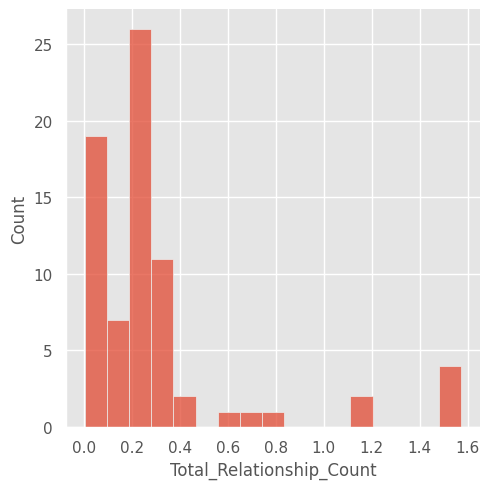

In [41]:
sns.displot(shap_explained_df[shap_explained_df['Mismatch']==True][feature].abs())
X_test[(shap_explained_df['Mismatch']==True).values].describe()
print(fit.predict(X_test[(shap_explained_df['Mismatch']==True).values]))

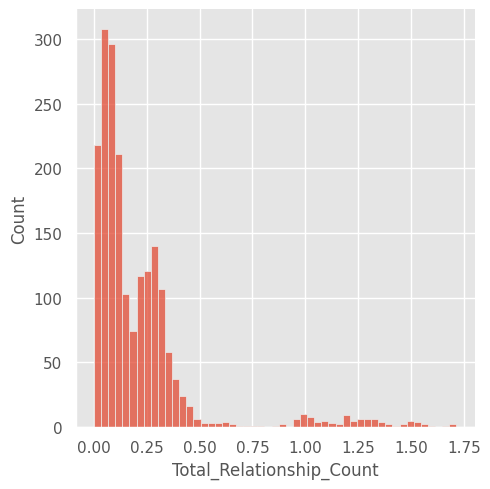

In [42]:
sns.displot(shap_explained_df[shap_explained_df['Mismatch']==False][feature].abs())

In [43]:

from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

bbox = sklearn_classifier_wrapper(fit)   

limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
lime_df = pd.concat([X_train, y_train], axis=1)
inst = X_train.iloc[88].values
limeExplainer.fit(lime_df, 'Attrition_Flag', config)
# lime_exp = limeExplainer.explain(inst)
# print(lime_exp.exp.as_list())

# Create new dataset with the features of lime from the test set
explained_entries = []
for entry, y_gt in zip(X_test.values, y_test.values):
    exp_list = limeExplainer.explain(entry).exp.as_list()
    dict_entry = {}
    for exp in exp_list:
        dict_entry[exp[0]] = exp[1]
    y_hat = fit.predict([entry])
    # Predict the entry if y_gt different from the prediction
    dict_entry["Mismatch"] = (y_gt != y_hat).item()
    explained_entries.append(dict_entry)

# Create dataframe
lime_explained_df = pd.DataFrame(explained_entries)

# Replace nan with zeros
#explained_df = explained_df.fillna(0)
lime_explained_df.head()

sns.barplot(lime_explained_df[lime_explained_df['Mismatch']==False].drop(columns=['Mismatch']))
plt.savefig(f'{PLOT_PATH}/lime_match')
plt.xticks(rotation=30)
plt.close()
sns.barplot(lime_explained_df[lime_explained_df['Mismatch']==True].drop(columns=['Mismatch']))
plt.xticks(rotation=30)
plt.savefig(f'{PLOT_PATH}/lime_mismatch')
plt.close()
correlation_heatmap(lime_explained_df, name=f'{PLOT_PATH}/lime_correlation_heatmap')
plt.close()

In [44]:
imp_features = ['Months_Inactive_12_mon', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count', 'Contacts_Count_12_mon']

In [45]:
### Correct remain
idx = 15
inst = X_test.iloc[idx].values
print('Instance ',X_test[imp_features].iloc[idx])
print('True class ',y_test.iloc[idx])
print('Predicted class ', fit.predict(inst.reshape(1, -1)))
exp = shapExplainer.explain(inst)
exp.plot_features_importance()

Instance  Months_Inactive_12_mon     -0.337598
Total_Trans_Amt            -0.023870
Total_Trans_Ct             -0.036585
Total_Revolving_Bal         1.060420
Total_Ct_Chng_Q4_Q1        -0.118203
Total_Relationship_Count   -1.166148
Contacts_Count_12_mon      -0.411616
Name: 8410, dtype: float64
True class  1
Predicted class  [1]


alt.VConcatChart(...)

In [46]:
### Wrong remain
idx = 16
inst = X_test.iloc[idx].values
print('Instance ',X_test[imp_features].iloc[idx])
print('True class ',y_test.iloc[idx])
print('Predicted class ', fit.predict(inst.reshape(1, -1)))
exp = shapExplainer.explain(inst)
exp.plot_features_importance()

Instance  Months_Inactive_12_mon     -1.327136
Total_Trans_Amt            -0.984435
Total_Trans_Ct             -1.399945
Total_Revolving_Bal         1.661686
Total_Ct_Chng_Q4_Q1        -1.592814
Total_Relationship_Count    0.120579
Contacts_Count_12_mon      -1.315636
Name: 1062, dtype: float64
True class  0
Predicted class  [1]


alt.VConcatChart(...)

In [47]:
#### Wrong goaway

idx = 26
inst = X_test.iloc[idx].values
print('Instance ',X_test[imp_features].iloc[idx])
print('True class ',y_test.iloc[idx])
print('Predicted class ', fit.predict(inst.reshape(1, -1)))
exp = shapExplainer.explain(inst)
exp.plot_features_importance()

Instance  Months_Inactive_12_mon     -0.337598
Total_Trans_Amt            -0.524906
Total_Trans_Ct             -0.675660
Total_Revolving_Bal        -1.426858
Total_Ct_Chng_Q4_Q1         0.431443
Total_Relationship_Count    1.407306
Contacts_Count_12_mon       1.396424
Name: 2666, dtype: float64
True class  1
Predicted class  [0]


alt.VConcatChart(...)

In [48]:
print(np.argwhere(y_test == 0).reshape((-1)))

[   4   12   16   35   46   49   58   61   66   79   83   87  100  102
  106  109  117  123  129  137  139  141  145  150  157  166  172  176
  188  189  209  215  216  218  219  228  229  238  239  240  243  253
  259  262  272  292  293  302  306  316  320  322  323  325  330  334
  341  354  355  374  377  379  389  390  393  394  404  409  411  414
  418  423  429  433  434  442  451  458  465  498  500  501  505  511
  515  522  528  537  542  550  559  567  574  577  580  587  593  594
  610  611  615  624  625  637  639  643  660  670  675  682  683  688
  696  703  712  713  714  716  718  722  730  738  752  761  764  768
  772  773  777  800  809  822  824  827  830  835  836  838  839  841
  844  853  860  864  865  867  871  895  900  901  917  926  928  933
  938  942  947  967  968  971  978  979  984  999 1000 1001 1017 1019
 1028 1033 1040 1045 1062 1066 1073 1076 1082 1083 1093 1095 1110 1122
 1134 1135 1141 1154 1158 1161 1165 1173 1182 1186 1193 1196 1197 1198
 1211 

In [49]:
#### Correct goaway
idx = 35
inst = X_test.iloc[idx].values
print('Instance ',X_test[imp_features].iloc[idx])
print('True class ',y_test.iloc[idx])
print('Predicted class ', fit.predict(inst.reshape(1, -1)))
exp = shapExplainer.explain(inst)
exp.plot_features_importance()

Instance  Months_Inactive_12_mon      0.651940
Total_Trans_Amt            -0.549340
Total_Trans_Ct             -0.973895
Total_Revolving_Bal         0.680027
Total_Ct_Chng_Q4_Q1        -1.311838
Total_Relationship_Count   -0.522785
Contacts_Count_12_mon       0.492404
Name: 4649, dtype: float64
True class  0
Predicted class  [0]


alt.VConcatChart(...)

In [50]:
y_test_pred = fit.predict(X_test)
print(np.argwhere(y_test_pred != y_test).reshape((-1)))

[   4   16   26   46  129  137  172  229  232  243  253  292  313  325
  340  354  505  550  577  587  595  610  611  637  639  643  688  696
  761  781  826  835  871  901  902  947  984 1001 1033 1039 1071 1082
 1134 1135 1244 1263 1267 1288 1289 1384 1387 1388 1434 1481 1483 1538
 1548 1559 1568 1576 1622 1673 1696 1732 1782 1784 1787 1880 1881 1964
 1994 2007 2009 2020]
